In [3]:
from IPython.display import Image

# VALORES MISSING, OUTLIERS Y CORRELACIONES

En este notebook se realiza el estudio y preprocesamiento de las variables numéricas y categoricas. Se realizarán los siguientes pasos:

   1. Cambio de tipos de variables
   2. Análisis de cada variable con gráficos descriptivos
   3. Para variables numericas: correlaciones de pearson, estudio de  outliers y de valores missing
   4. Para variables categoricas: estudio de correlaciones con vCramer

Para los valores outlier por columnas, se tendrá en cuenta los gráficos:

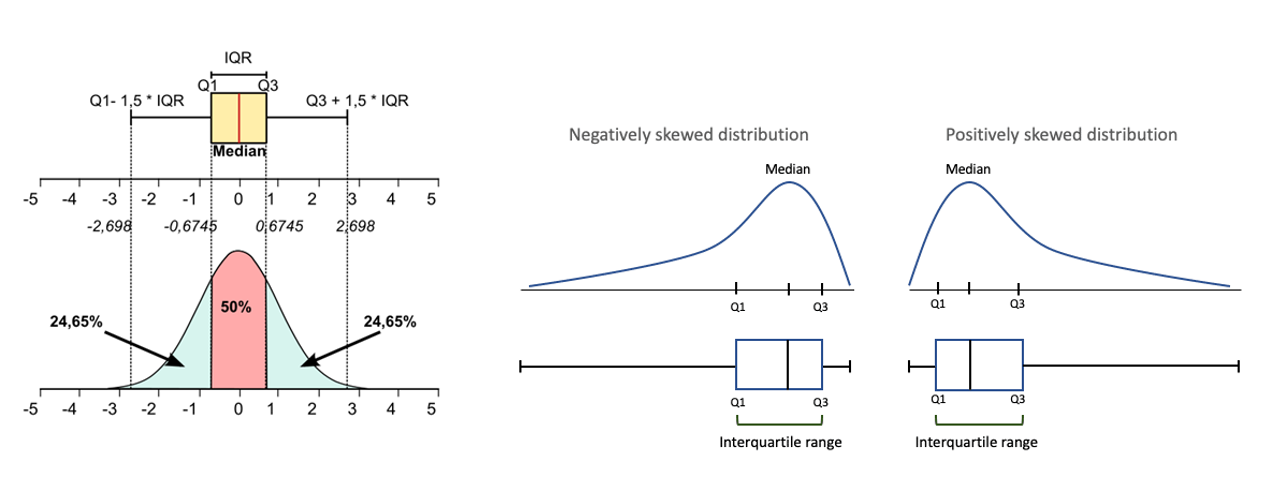

Dentro del tratamiento de los valores missing, se elegirá alguno de los siguientes métodos:

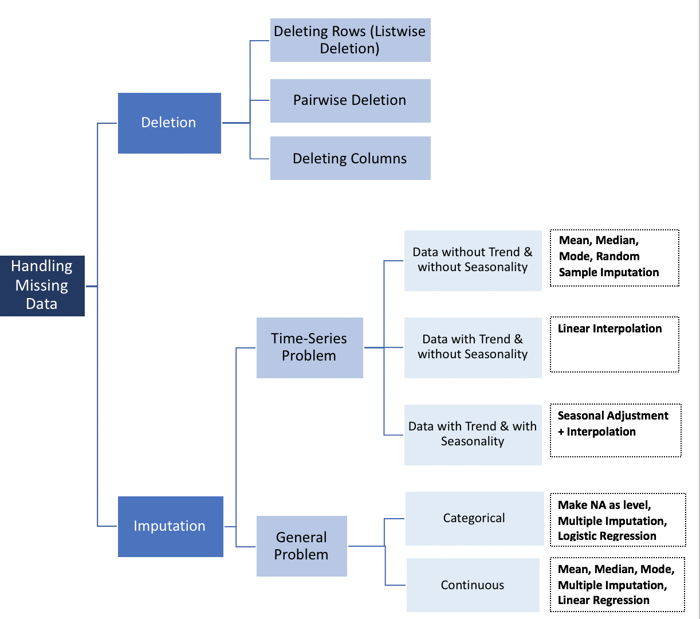

## Importo librerías

En primer lugar, se importan las librerías necesarias.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

## Funciones

In [6]:
def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the fraud.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df, x=col_name, color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    

def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
        -Descripción: Función que recibe un dataset y devuelve una lista con los nombres de las 
        variables categóricas
        -Inputs: 
            -- dataset: Pandas dataframe que contiene los datos
        -Return:
            -- lista_variables_categoricas: lista con los nombres de las variables categóricas del
            dataset de entrada con menos de 100 valores diferentes
            -- 1: la ejecución es incorrecta
    '''
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other


def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    corr = dataset.corr(method=metodo) 
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    f, ax = plt.subplots(figsize=size_figure)
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) 
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_fraud, list_var_continuous, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_fraud[i].mean()
        series_std = pd_fraud[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_fraud[i].size
        
        perc_goods = pd_fraud[i][(pd_fraud[i] >= left) & (pd_fraud[i] <= right)].size/size_s
        perc_excess = pd_fraud[i][(pd_fraud[i] < left) | (pd_fraud[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_fraud[target][(pd_fraud[i] < left) | (pd_fraud[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('fraud_bool',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_fraud[i][(pd_fraud[i] < left) | (pd_fraud[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final


def get_percent_null_values_target(pd_fraud, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_fraud[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_fraud[target][pd_fraud[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('fraud_bool',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_fraud[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_fraud[i].isnull().sum()/pd_fraud.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final



def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

## Lectura de datos del preprocesado inicial
Lectura de los datos y cambio de tipos de variables

In [7]:
pd_fraud = pd.read_csv("Base.csv")
pd_fraud.shape

(1000000, 32)

In [8]:
pd_fraud.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [9]:
pd_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

Creación de una lista que recoge las variables categóricas del dataset:

In [10]:
lista_variables_categoricas = ["payment_type","employment_status","housing_status","email_is_free","phone_home_valid",
                                "phone_mobile_valid","has_other_cards","foreign_request","source","device_os","keep_alive_session"]

In [11]:
pd_fraud.nunique()

fraud_bool                               2
income                                   9
name_email_similarity               998861
prev_address_months_count              374
current_address_months_count           423
customer_age                             9
days_since_request                  989330
intended_balcon_amount              994971
payment_type                             5
zip_count_4w                          6306
velocity_6h                         998687
velocity_24h                        998940
velocity_4w                         998318
bank_branch_count_8w                  2326
date_of_birth_distinct_emails_4w        40
employment_status                        7
credit_risk_score                      551
email_is_free                            2
housing_status                           7
phone_home_valid                         2
phone_mobile_valid                       2
bank_months_count                       33
has_other_cards                          2
proposed_cr

Con .nunique() podemos observar los valores únicos que toman las variables del dataset. Nos fijamos en las variables categóricas y comprobamos que puesto que no presentan una gran cantidad de valores únicos, podremos trabajar bien con ellas en este proyecto. LLama la atención que la variable categórica 'device_fraud_count' tome únicamente un valor, información que se contemplará en el apartado de selección de variables.

Observamos que dentro de nuestro dataset hay tanto variables categóricas (tal y como se ha visto en el notebook 01), variables float (continuas) y variables int (números enteros).

A continuación convertimos las columnas de 'lista_variables_categoricas' en el DataFrame 'pd_fraud' al tipo de dato 'category' utilizando el método astype('category'):

In [12]:
for columna in lista_variables_categoricas:
    pd_fraud[columna] = pd_fraud[columna].astype('category')
    
lista_variables_categoricas

['payment_type',
 'employment_status',
 'housing_status',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'foreign_request',
 'source',
 'device_os',
 'keep_alive_session']

A continuación transformamos 5 de las variables de 'pd_fraud' a formato decimal.

In [13]:
pd_fraud['prev_address_months_count']= pd_fraud['prev_address_months_count'].astype(float)
pd_fraud['current_address_months_count']= pd_fraud['current_address_months_count'].astype(float)
pd_fraud['zip_count_4w']= pd_fraud['zip_count_4w'].astype(float)
pd_fraud['bank_branch_count_8w']= pd_fraud['bank_branch_count_8w'].astype(float)
pd_fraud['credit_risk_score']= pd_fraud['credit_risk_score'].astype(float)

Creamos dos nuevas variables con las variables numéricas y la target (fraud_bool').

In [26]:
lista_variables_numericas = ["income", "name_email_similarity", "prev_address_months_count", "current_address_months_count", "customer_age", "days_since_request",
                            "intended_balcon_amount", "zip_count_4w", "velocity_6h", "velocity_24h", "velocity_4w", "bank_branch_count_8w", "date_of_birth_distinct_emails_4w",
                            "credit_risk_score", "bank_months_count", "proposed_credit_limit", "session_length_in_minutes", "device_distinct_emails_8w", "device_fraud_count",
                            "month"]
target = 'fraud_bool'

La variable objetivo 'fraud_bool' es una variable booleana que toma valores 0 y 1, como se ha indicado previamente. A través de la siguiente línea de código se muestra qué las observacioness de 'fraud_bool'= 0 son muy superiores a cuando 'fraud_bool'= 1. Por ello, será necesario balancear los datos, proceso que se llevará a cabo en el notebook 5.

In [24]:
pd_fraud['fraud_bool'].value_counts()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

## Visualización descriptiva de los datos

Distribución de las variables

In [25]:
pd_fraud.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

La siguiente celda del código se utiliza para realizar visualizaciones de las características en el DataFrame. Este enfoque facilita obtener una comprensión rápida de cómo diferentes características se relacionan con la variable objetivo.

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ver

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ver

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ver

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\sarim\AppData\Local\Temp\ipykernel_30324\2343862388.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df.groupby(col_name)[target].value_counts(normalize

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ver

C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sarim\anaconda3\envs\practicaEDA\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

CPU times: total: 2min 32s
Wall time: 4min 32s


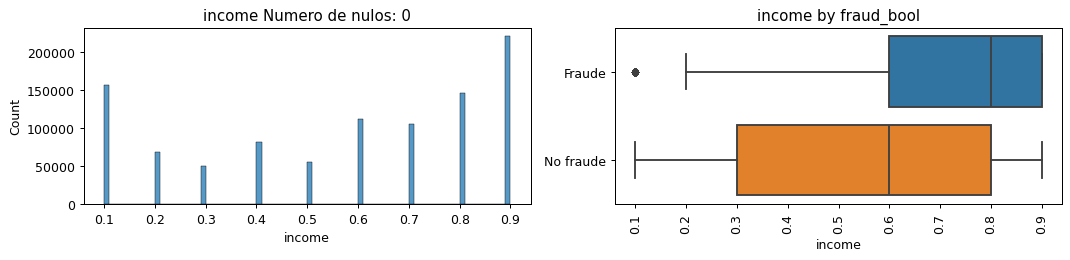

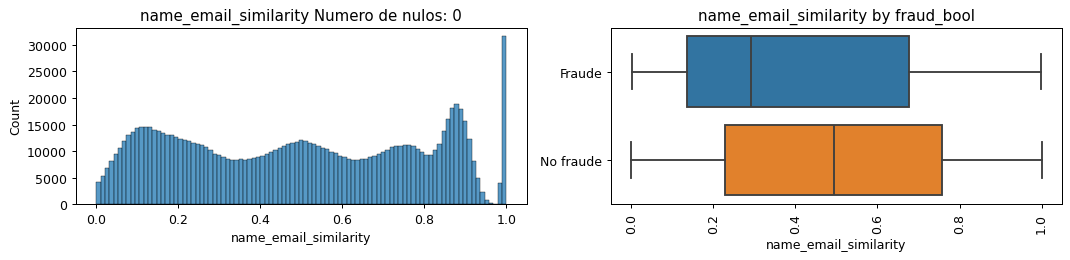

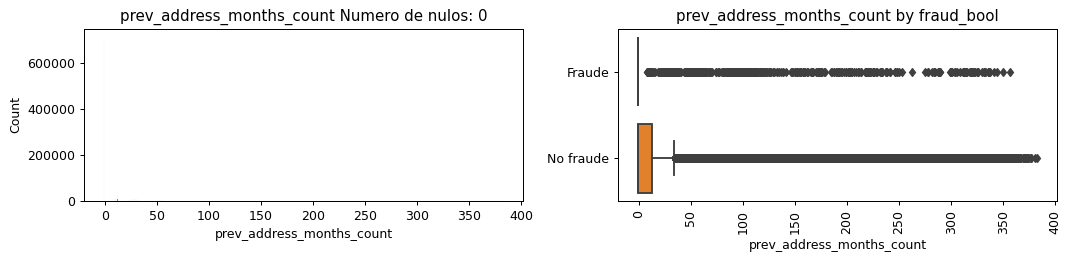

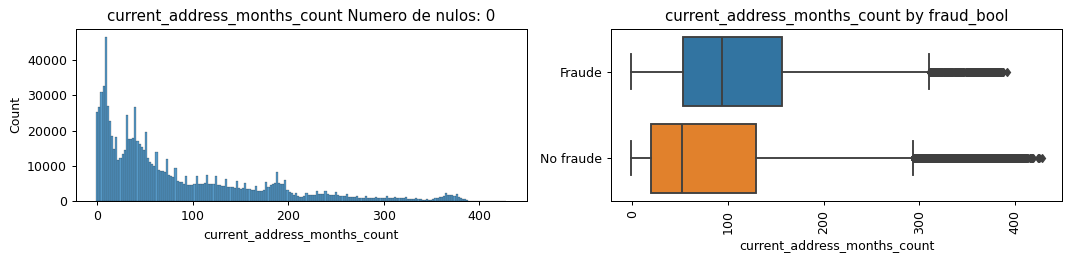

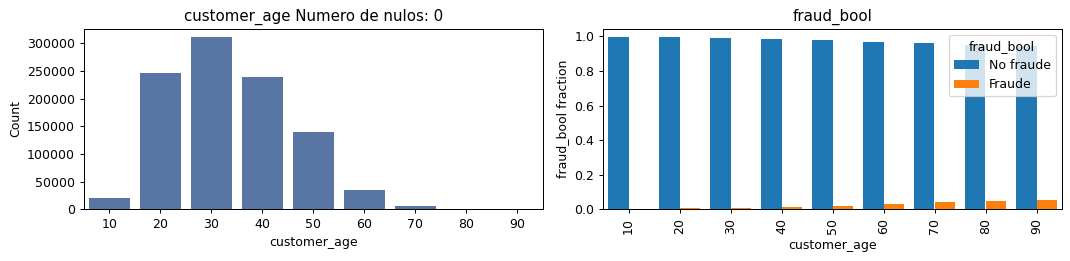

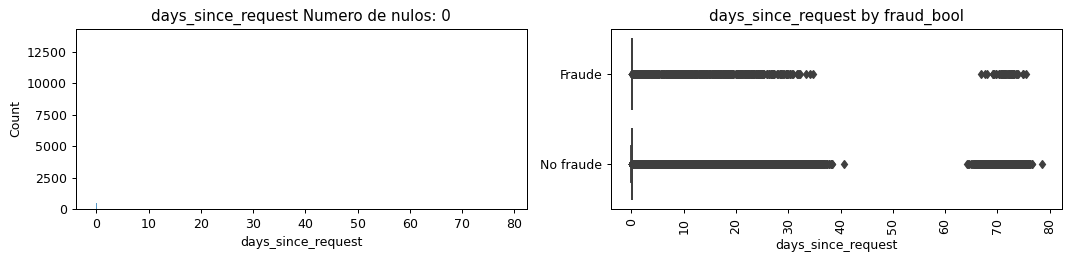

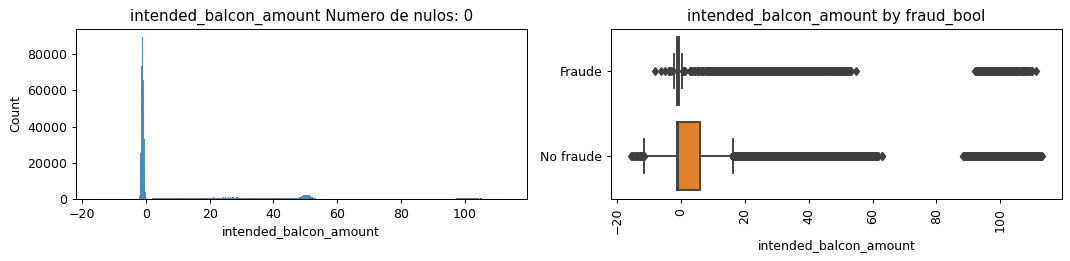

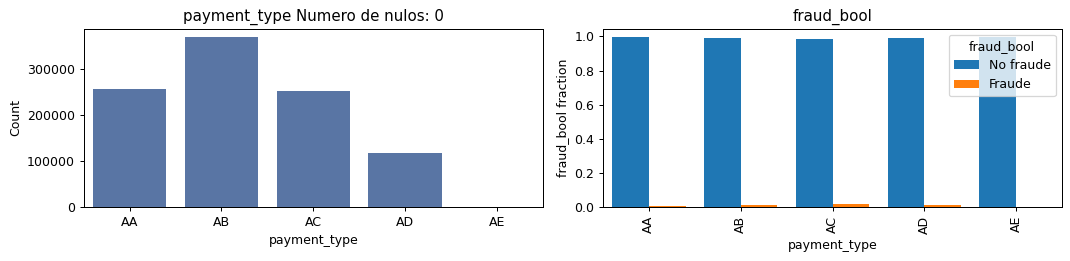

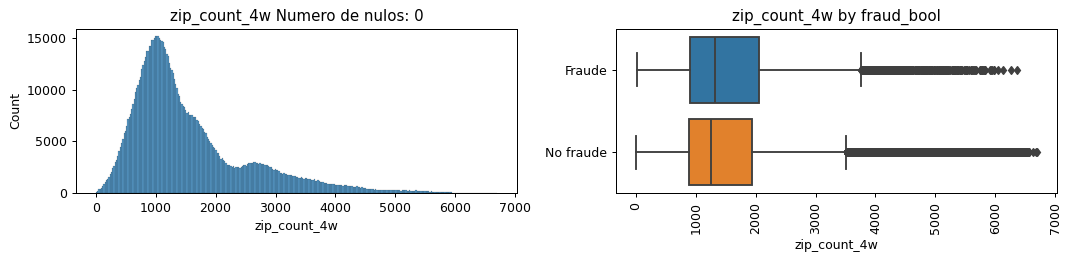

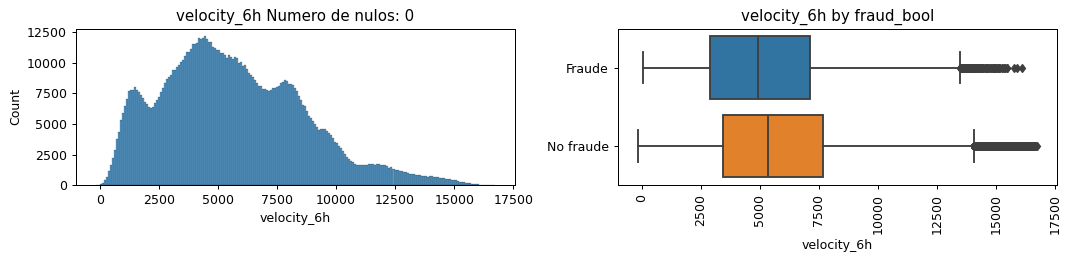

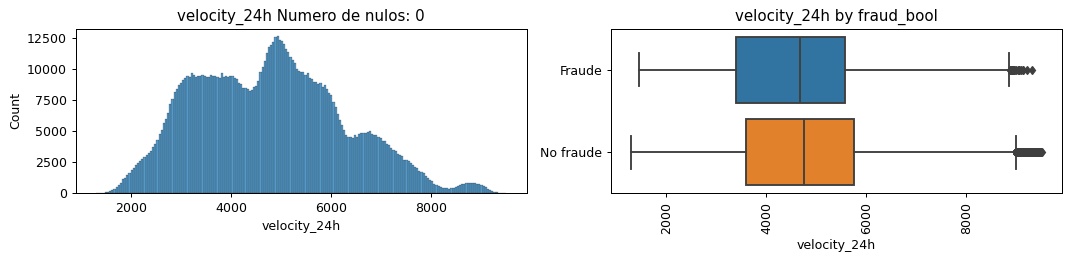

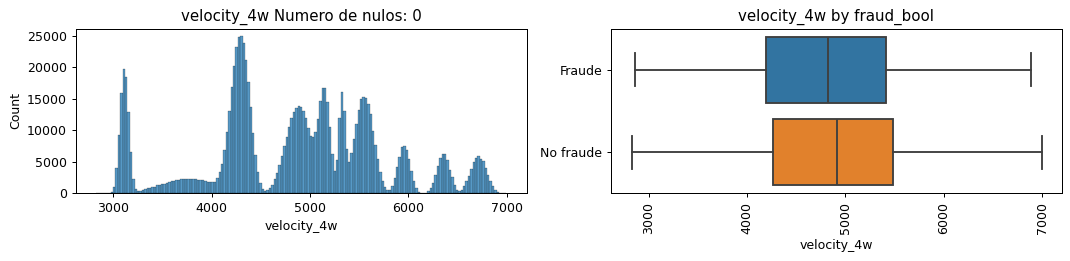

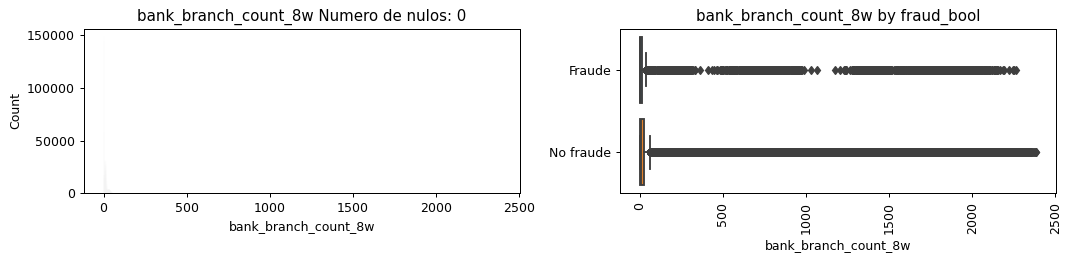

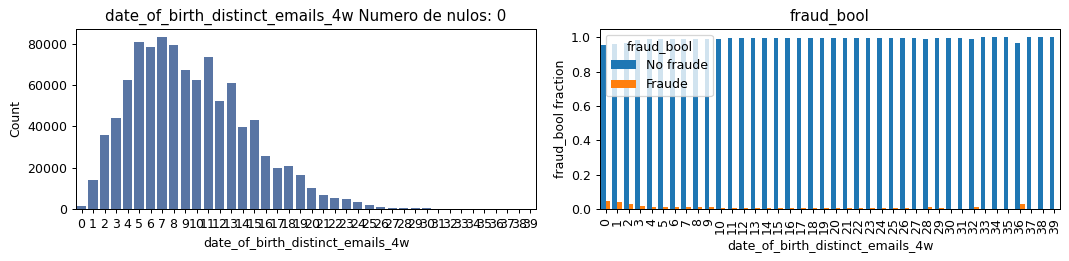

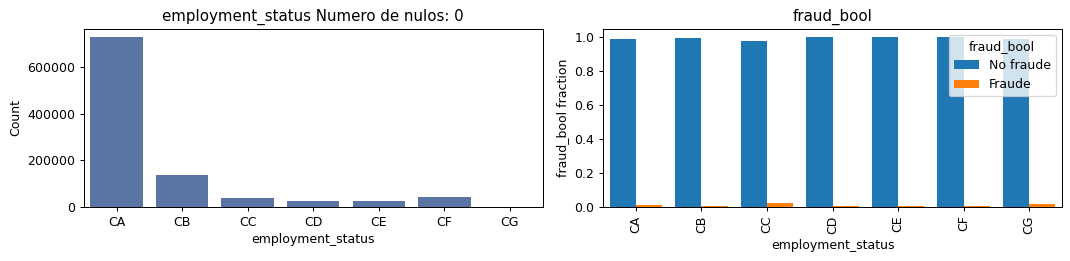

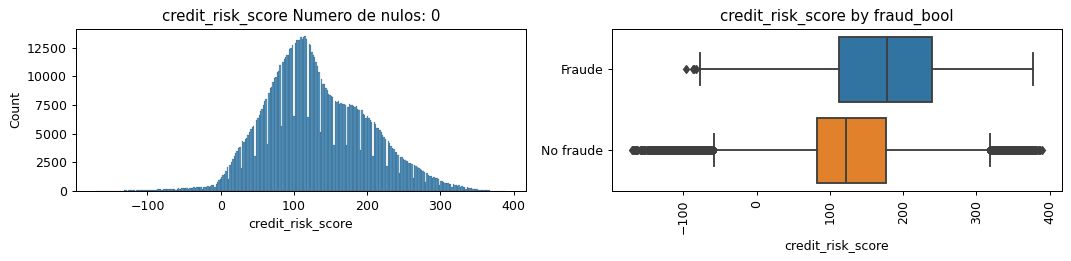

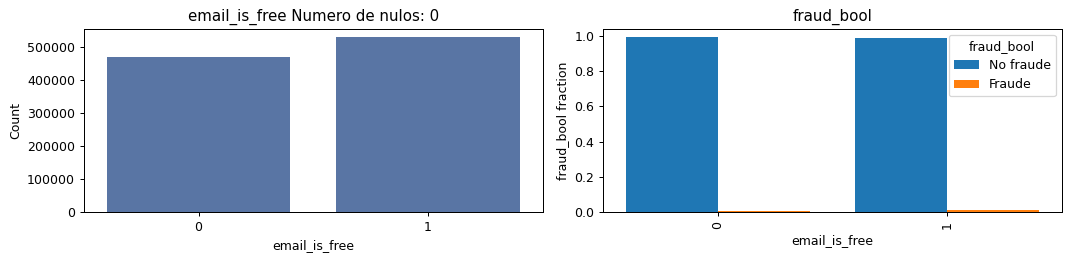

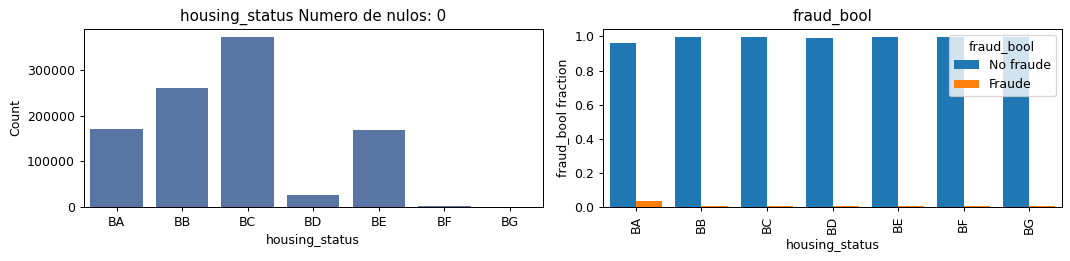

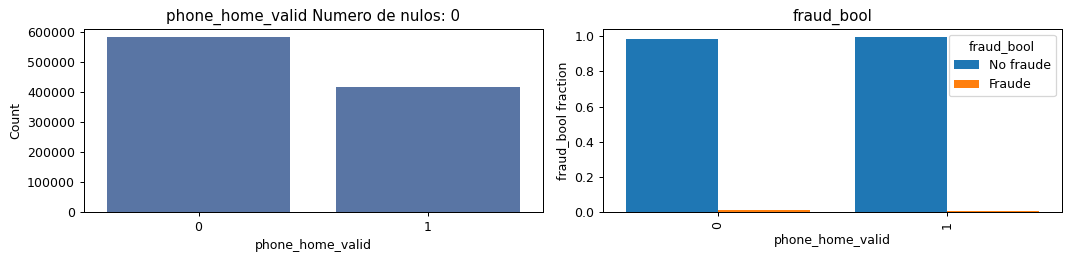

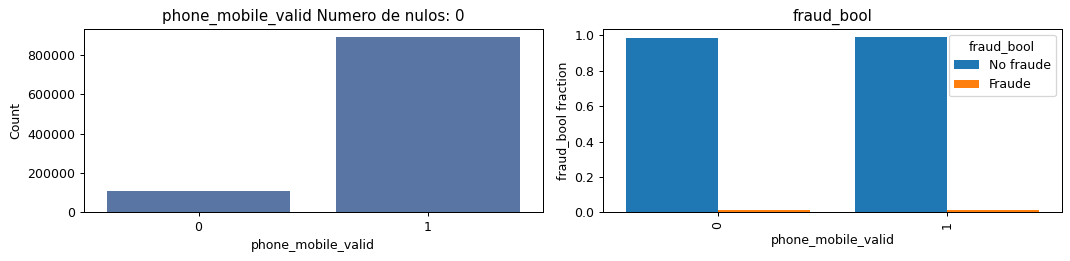

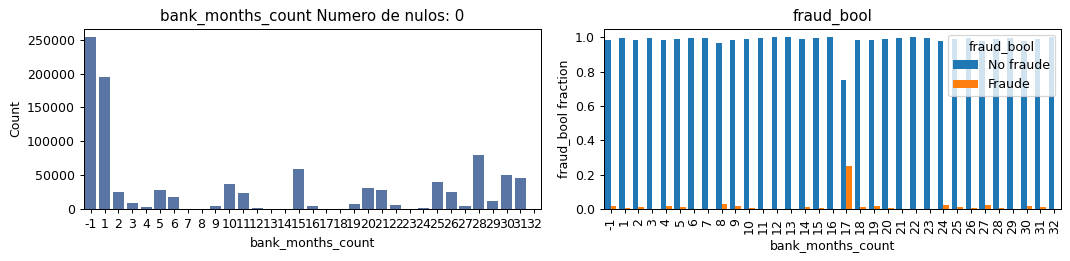

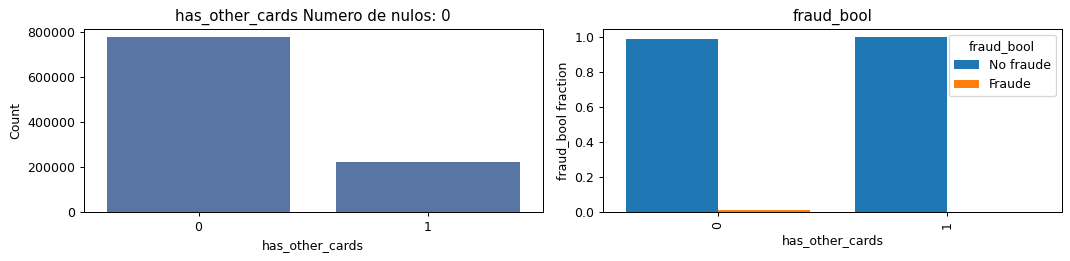

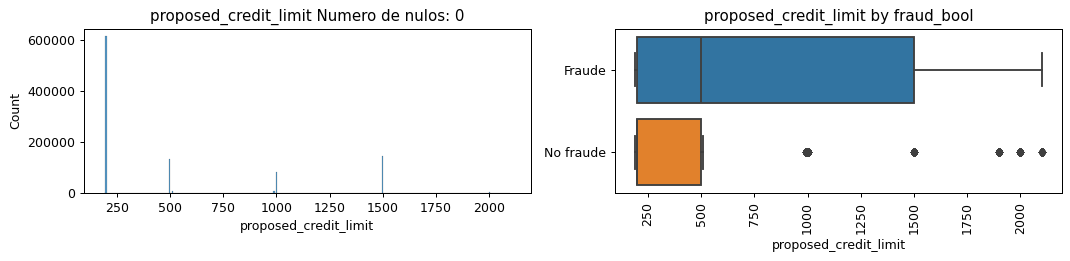

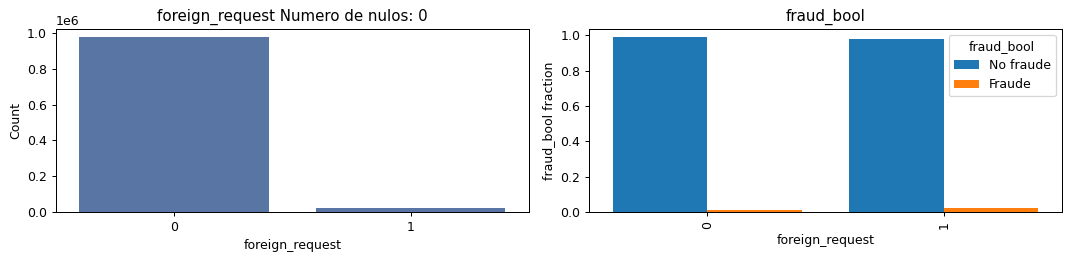

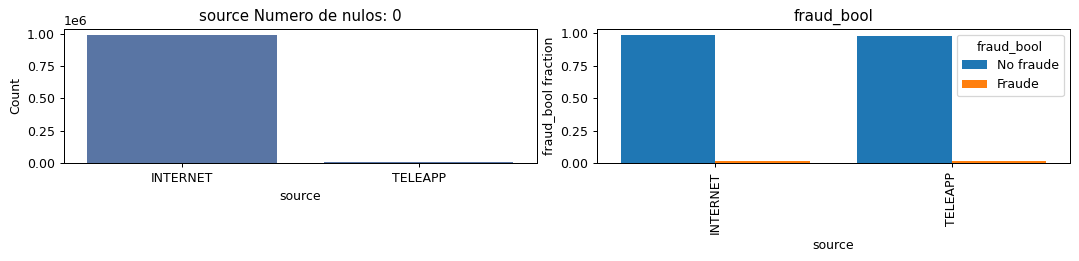

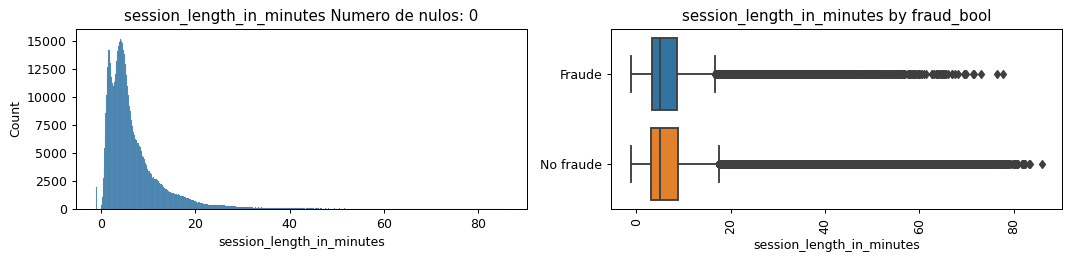

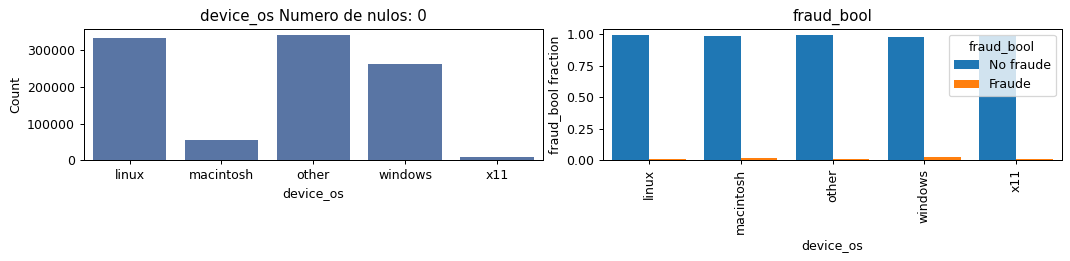

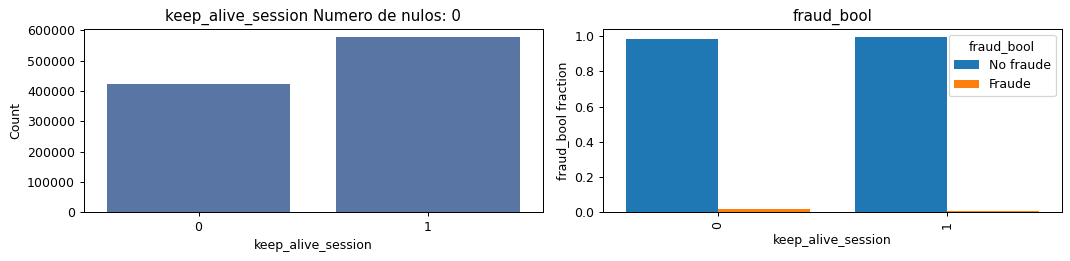

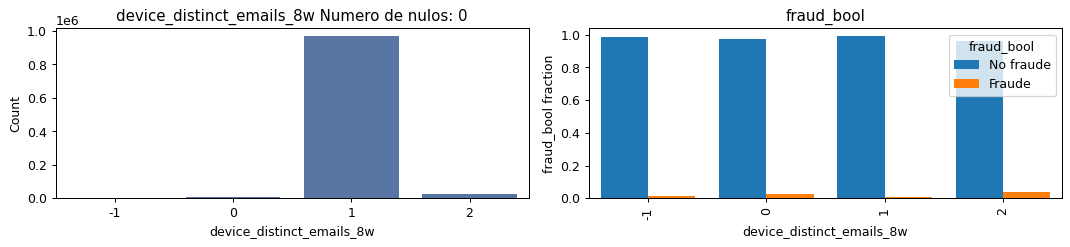

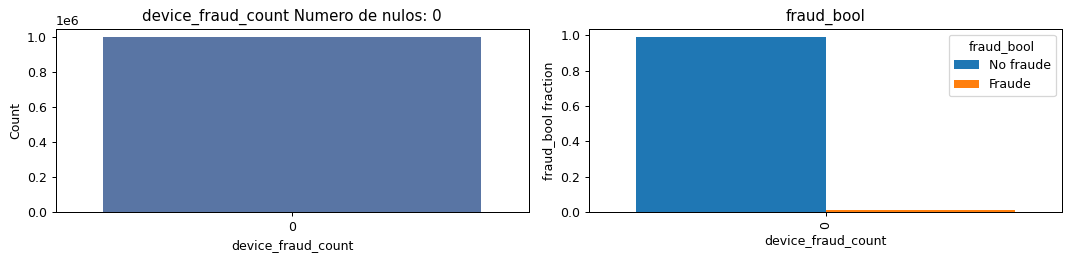

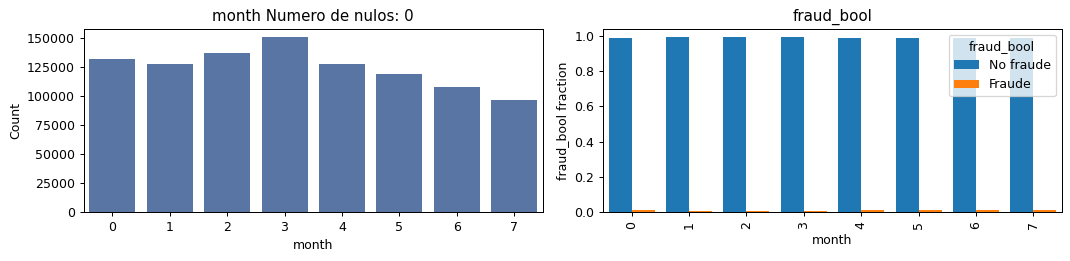

In [16]:
%%time
for i in list(pd_fraud.columns):
    if (pd_fraud[i].dtype==float) & (i!='fraud_bool'):
        plot_feature(pd_fraud, col_name=i, isContinuous=True, target='fraud_bool')
    elif  i!='fraud_bool':
        plot_feature(pd_fraud, col_name=i, isContinuous=False, target='fraud_bool')

#### Comentarios de los gráficos

Comentarios de los gráficos más relevantes:

 - En el primer gráfico boxplot podemos ver que hay una diferencia clara entre las medias de 'income' cuando medimos los datos fraudulentos contra los no fraudulentos, siendo mucho mayor en los casos en los que se comete fraude. Esto puede llevar a pensar que las cuentas con más income tienden a ser fraudulentas. Un estudio más profundo sobre esta relación podría ser interesante.
 - Como podemos ver en el gráfico de barras de 'name_email_similarity', la mayoría de la gente pone su nombre en la dirección del email. En el boxplot no hay diferencias significativas por lo que probablemente no tenga relación el nombre del email con la posibilidad de que las aplicaciones sean fraudulentas o no.
 - Observamos que los dos bigotes de la caja boxplot de la variable 'prev_address_months_count' indica que al menos el 50% de las aplicaciones fraudulentas presentan esta variable como valor faltante. Esta variable podría ser relevante para detectar los fraudes.
 - El gráfico de barras de la variable 'customer_age' muestra un dato muy relevante: que se utilizan cuentas de personas más mayores para generar aplicaciones fraudulentas. 
 - En el histograma de 'intended_balcon_amount' podemos ver que casi nunca se introduce dinero al iniciar una aplicación. Eso sumado a que los gráficos boxplots son muy parecidos, indica que esta variable no sería muy útil para el estudio.
 - En el gráfico de barras de 'date_of_birth_distinct_emails_4w' observamos que hay 4 semanas dignas de mención (0,1,2,36). Un estudio más a fondo podría ser interesante.
 - A pesar de que en el histograma de 'employment_status' se observen que el que más se repiten son los CA y que los grupos CC y en especial CG apenas carecen de aplicaciones, en el gráfico de barras observamos que el employment_status CC y CG tiende a ser utilizado para crear aplicaciones fraudulentas.
 - A pesar de que en el histograma de 'housing_status' se observen que el que más se repiten son los BC, en el gráfico de barras observamos que el housing_status BA tiende a ser más utilizado para crear aplicaciones fraudulentas.
 - En el gráfico de barras de 'bank_months_count' observamos que los usuarios crean más cuentas fraudulentas cuando la cuenta bancaria de un cliente tiene 17 meses.
 - En el boxplot de 'proposed_credit_limit' se muestra que las aplicaciones fraudulentas se tienden a crear con un límite de cuenta mayor, lo que tiene lógica puesto que se quiere obtener confianza.
 - En el histograma de 'foreign_request' podemos ver que no hay muchas cuentas con esta variable igual a 1, y en el gráfico de barras entonces podemos observar una ligera diferencia. Cuentas con este valor se pueden llegar a utilizar más para crear aplicaciones fraudulentas.
 - Gráficos keep_alive_session: Las cuentas con aplicaciones fraudulentas tienden a dejarse la cuenta abierta lo cual tiene sentido porque así no se requiere introducir contraseñas.
 - Las aplicaciones fraudulentas es probable que se creen desde el mismo dispositivo, y esto puede explicar que en el gráfico de barras de 'device_distinct_emails_8w' el valor que más se repita sea el 2.
 
 - No se aprecian diferencias significativas en los gráficos boxplot ni información relevante en los histogramas: 'payment_type', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'source', 'device_os', 'current_adress_months_count', 'days_since_request', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'credit_risk_score', 'session_length_in_minutes', 'device_fraud_count'y 'month'.

A continuación, se tratan los valores missing, las correlaciones de las variables y los outliers

## Tratamiento de outliers

Los valores outlier se pueden sustituir por la media, mediana, valores extremos (media+3std o media-3std). Tras el siguiente análisis, hemos decidido como primera iteración dejarlos sin sustituir. Una vez lleguemos al modelo puedo realizar iteraciones utilizando diferentes métodos para comprobar si mejora el modelo.

In [27]:
pd_fraud.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1.0,88.0,50,0.020925,-1.331345,AA,769.0,10650.765523,3134.319630,3863.647740,1.0,6,CA,185.0,0,BA,1,0,24,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1.0,144.0,50,0.005418,-0.816224,AB,366.0,534.047319,2670.918292,3124.298166,718.0,3,CA,259.0,1,BA,0,0,15,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1.0,132.0,40,3.108549,-0.755728,AC,870.0,4048.534263,2893.621498,3159.590679,1.0,14,CB,177.0,1,BA,0,1,-1,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1.0,22.0,50,0.019079,-1.205124,AB,810.0,3457.064063,4054.908412,3022.261812,1921.0,6,CA,110.0,1,BA,0,1,31,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1.0,218.0,50,0.004441,-0.773276,AB,890.0,5020.341679,2728.237159,3087.670952,1990.0,2,CA,295.0,1,BA,1,0,31,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


Para realizar el análisis descriptivo de los outliers, la mejor forma de representarlos es con los gráficos boxplots.

Representaremos las variables continuas en forma de histograma y boxplot y las variables categóricas en gráficos de barras.

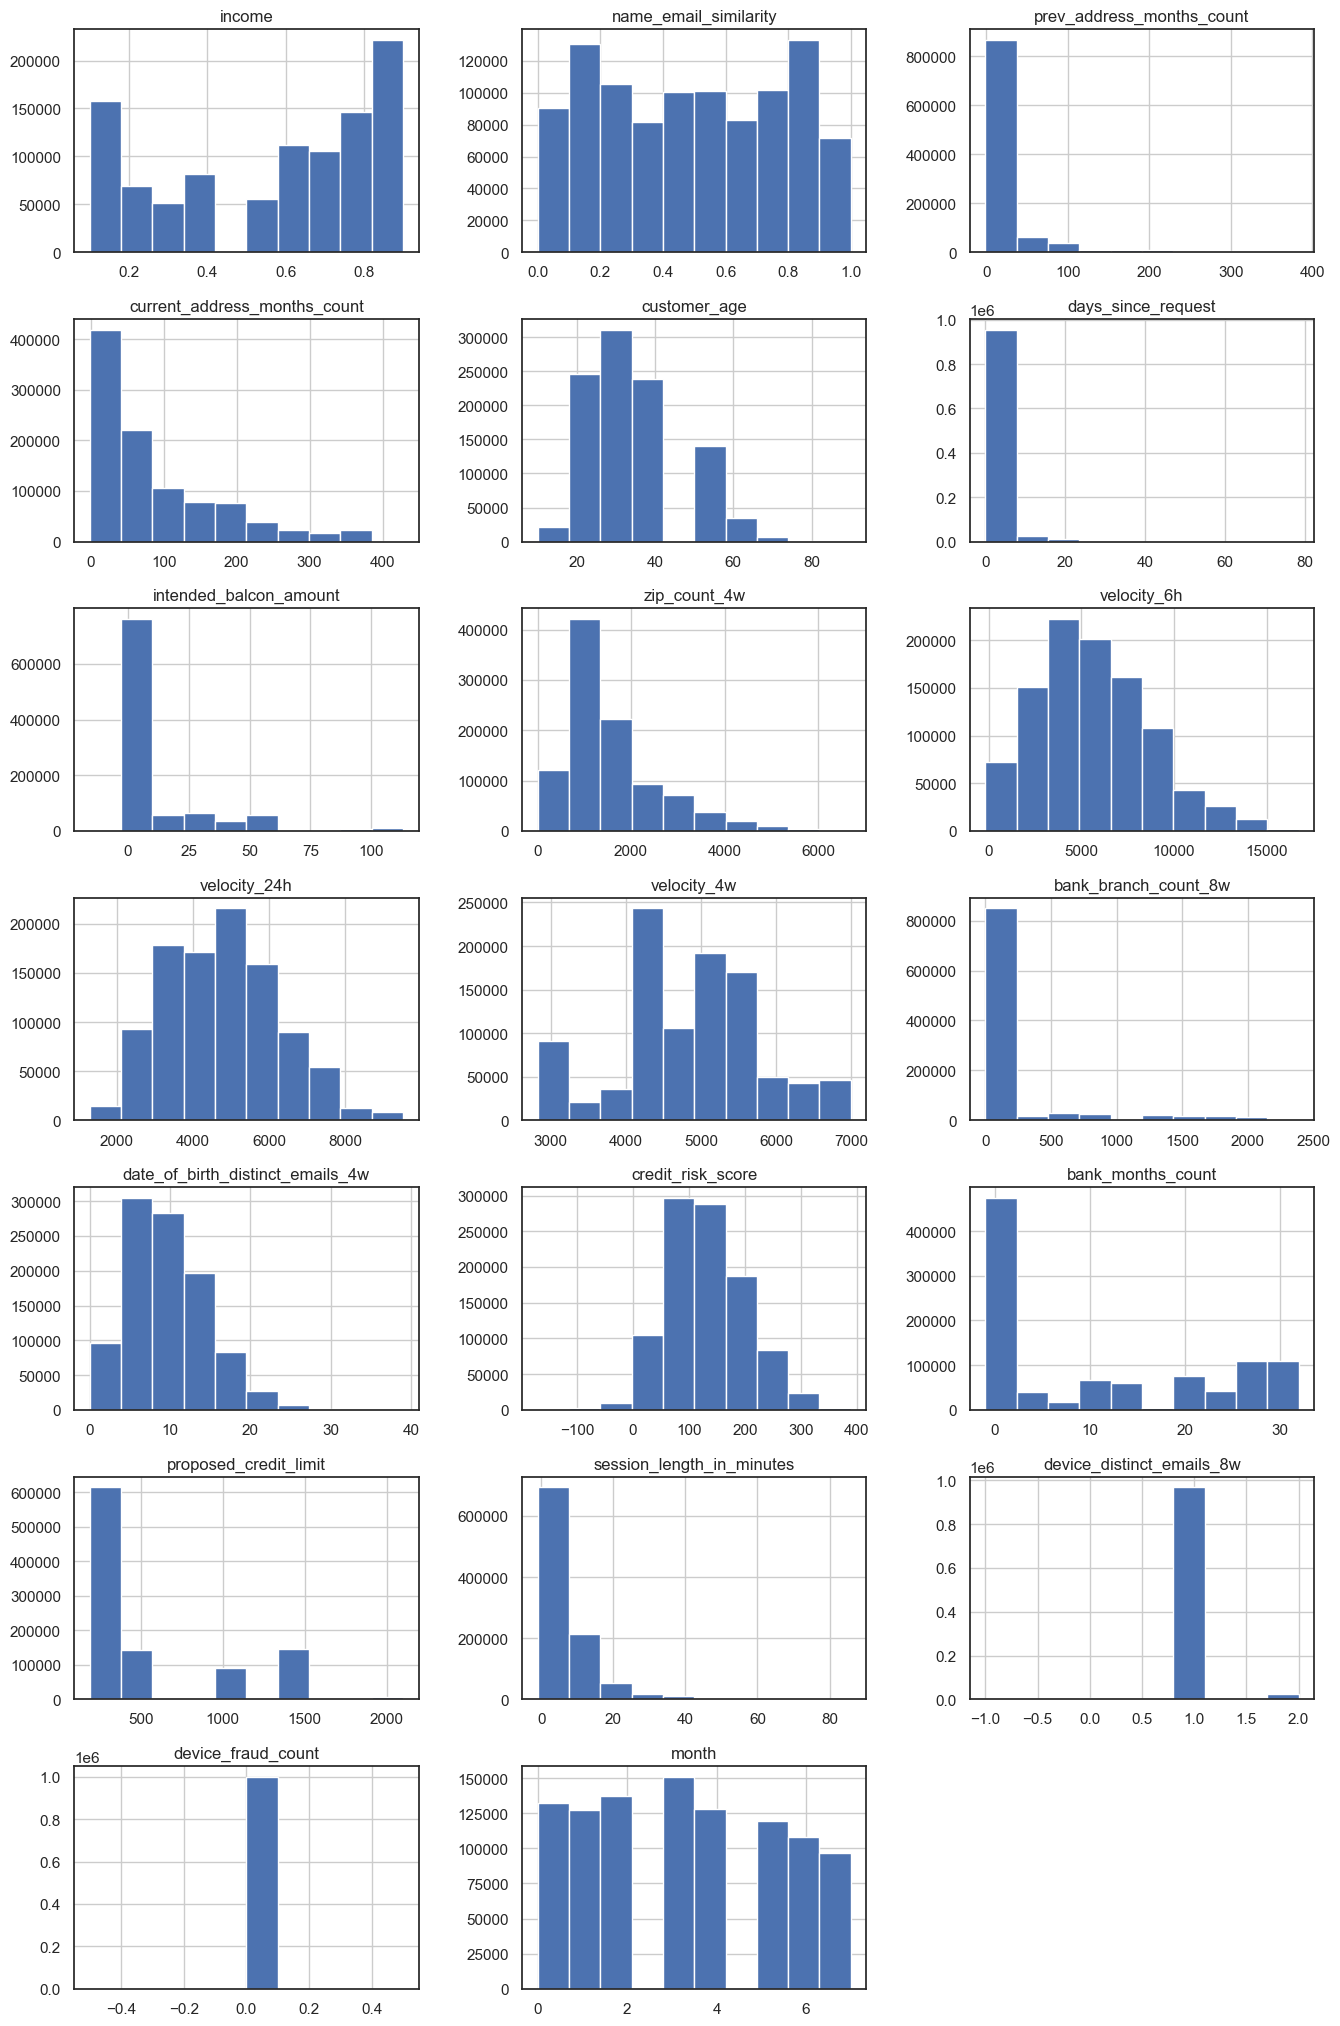

In [34]:
pd_fraud.hist(figsize=(16,48),layout=(13,3)) 
plt.show()

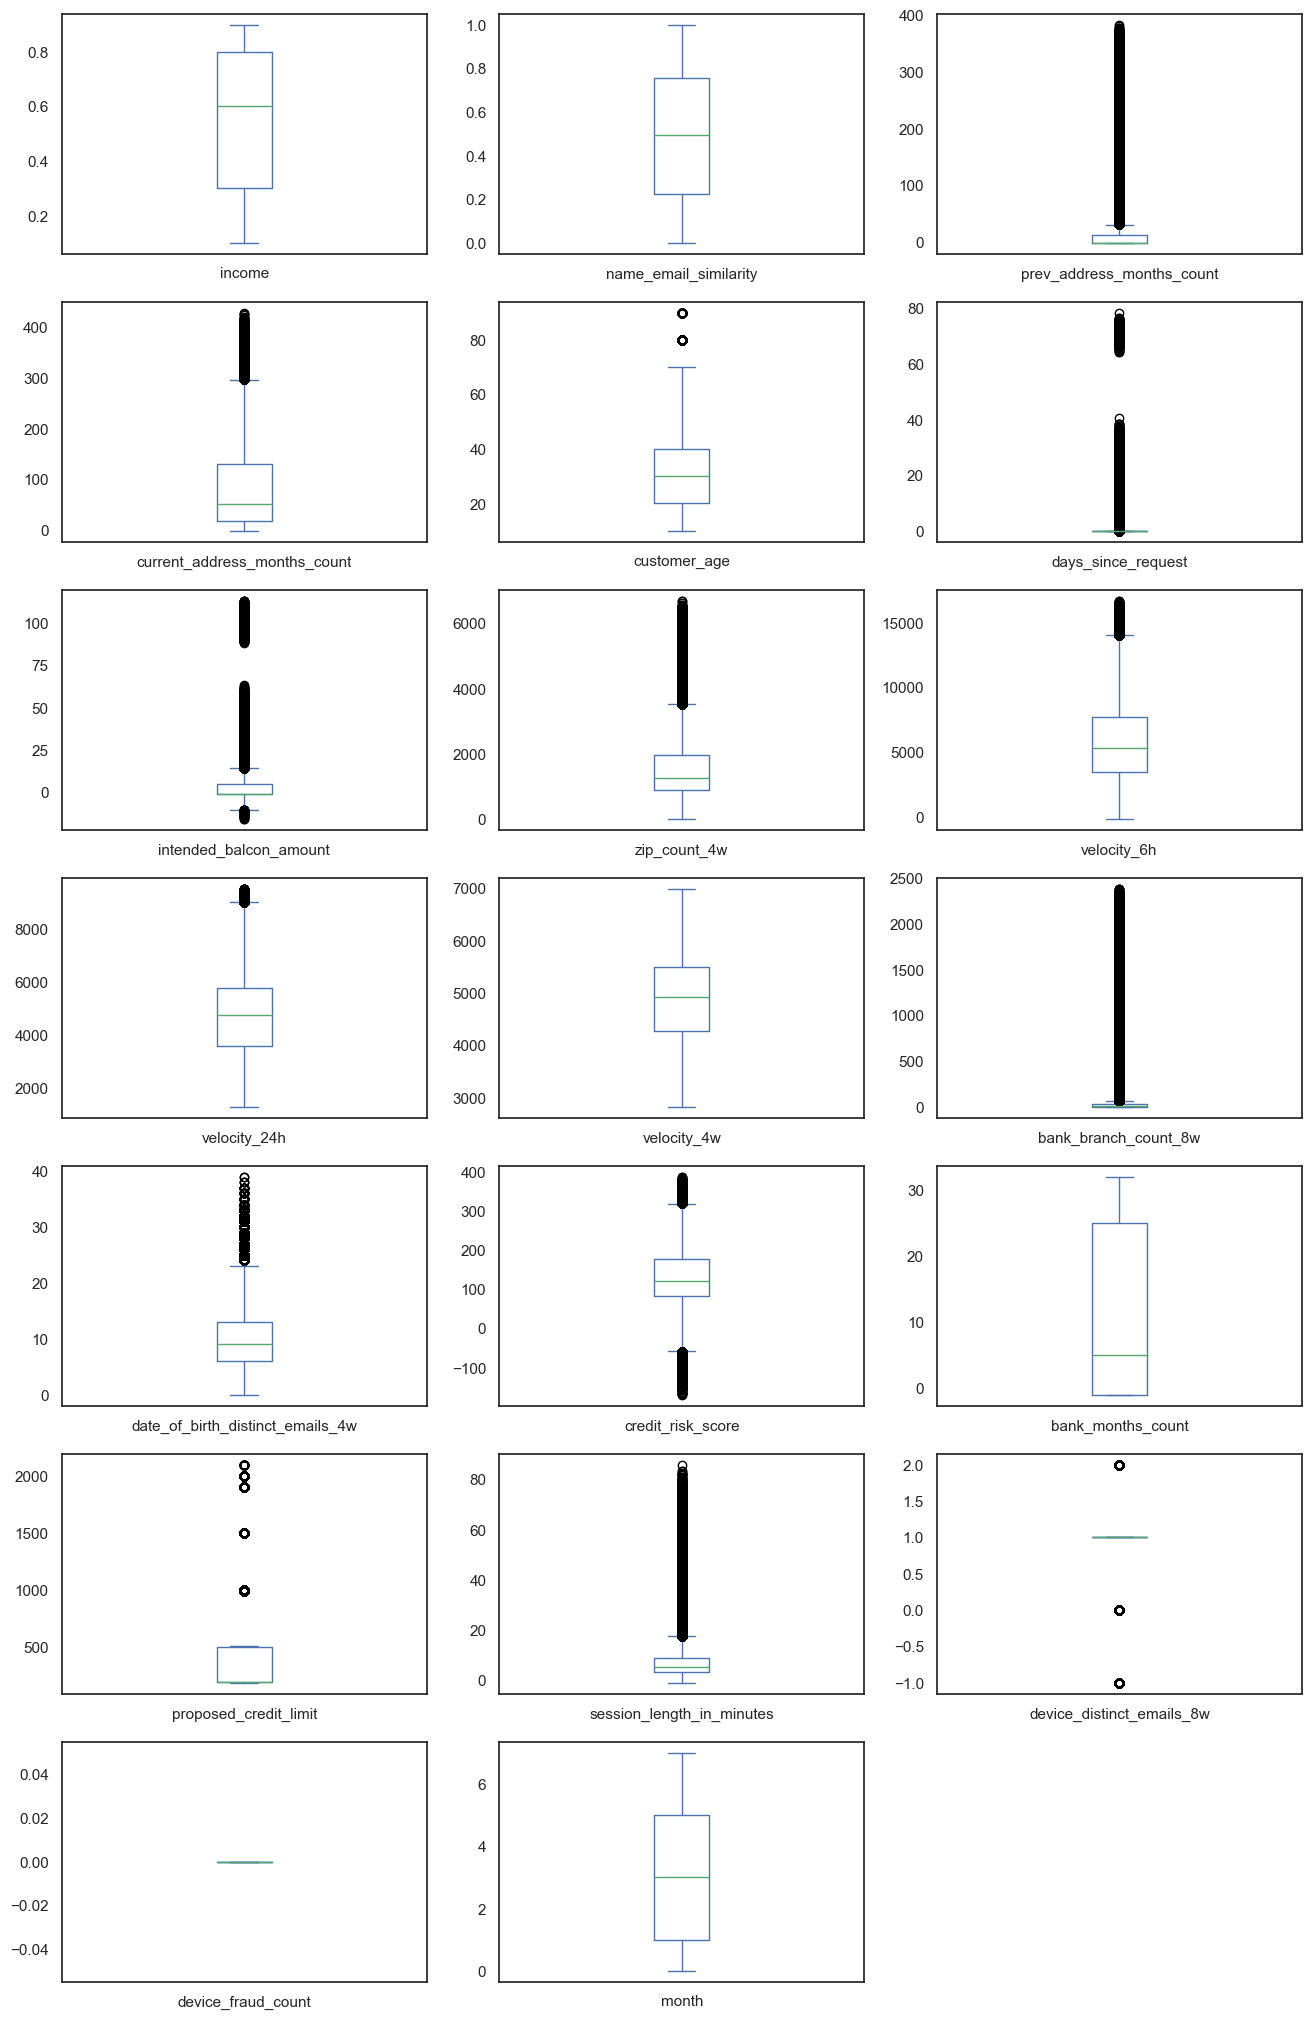

In [35]:
pd_fraud.plot(figsize=(16,48),kind='box', subplots=True,layout=(13,3),sharex=False, sharey=False)
plt.show()

Con respecto a la variable'customer_age' se observan dos outliers, sin embargo; puede que no sea nada fuera de lo común puesto que puede haber solicitantes que tengan más de 80 años.

En relación con la variable 'days_since_request' vemos que presenta un boxplot con una franja de valores vacía entre 45 y 63 días. A este hecho le damos como posible explicación que posiblemente no se pudieron hacer solicitudes durante esos días.

De nuevo, se comprueba que la variable 'device_fraud_count' únicamente toma el valor 0 por lo que es probable que en la selección de variables se elimine.

En resumen, no hemos encontrado outliers significativos que puedan dañar el análisis por lo que no vamos a realizar modificaciones sobre estos.

In [17]:
pd_fraud[pd_fraud['proposed_credit_limit']>1500]

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
12,1,0.9,0.451802,-1.0,107.0,30,0.035559,-0.050991,AC,1915.0,3017.526731,2295.067639,3653.963028,11.0,10,CA,296.0,1,BA,1,1,-1,0,2000.0,1,INTERNET,9.608223,linux,0,1,0,7
17,1,0.7,0.130322,-1.0,50.0,30,0.012563,-1.182489,AB,1180.0,1628.561553,4084.073290,3082.049852,18.0,5,CA,302.0,1,BA,0,1,25,0,2000.0,0,INTERNET,4.708033,windows,1,1,0,7
20,1,0.9,0.066695,-1.0,82.0,50,0.007176,-0.803946,AC,570.0,4350.738684,3134.771052,3094.241541,0.0,5,CA,234.0,1,BA,0,1,-1,0,1900.0,0,INTERNET,3.635425,linux,0,1,0,7
43,1,0.7,0.161950,289.0,209.0,40,0.008195,-0.837462,AC,679.0,1213.608342,2867.661501,3123.982404,1.0,10,CA,272.0,0,BA,1,0,-1,0,2000.0,0,INTERNET,9.366778,windows,0,1,0,7
55,1,0.9,0.744705,-1.0,26.0,40,0.008679,-0.752571,AB,1144.0,7726.575304,2566.778181,3127.754458,12.0,4,CA,320.0,1,BA,0,1,10,0,1900.0,1,INTERNET,4.301425,windows,0,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999519,0,0.1,0.819098,-1.0,111.0,40,0.003395,-0.926402,AC,937.0,1682.631756,4569.606396,4253.103670,1.0,8,CA,236.0,1,BA,0,1,-1,0,2000.0,0,INTERNET,3.195700,windows,1,1,0,4
999531,0,0.4,0.626494,-1.0,23.0,30,0.029525,-1.778377,AB,949.0,5577.148952,3471.263224,4258.803695,7.0,17,CA,199.0,1,BE,0,1,25,0,2000.0,1,INTERNET,3.657211,linux,0,1,0,4
999742,0,0.7,0.422322,-1.0,349.0,20,0.014427,-0.231483,AB,1068.0,4042.574707,5114.045442,4321.013411,13.0,15,CA,265.0,1,BA,0,1,28,0,2000.0,0,INTERNET,3.364279,other,1,1,0,4
999904,0,0.7,0.276363,-1.0,60.0,30,0.007415,-0.807705,AC,975.0,5539.952406,3647.788031,4796.981960,0.0,11,CB,222.0,0,BF,0,1,-1,0,2000.0,0,INTERNET,8.467225,linux,0,1,0,4


Al encontrar outliers en la variable 'proposed_credit_limit' hemos realizado un análisis más a fondo del motivo. Se observa que estas observaciones tienen un 'credit_risk_score' más alto, lo cual ofrece una explicación de los valores de 'proposed_credit_limit' tan altos y los dejamos dentro del análisis.

In [29]:
get_deviation_of_mean_perc(pd_fraud, lista_variables_numericas, target='fraud_bool', multiplier=3)

,0.0,1.0,variable,sum_outlier_values,porcentaje_sum_null_values
0,0.993836,0.006164,prev_address_months_count,25310,0.025310
1,0.984034,0.015966,current_address_months_count,21483,0.021483
2,0.958048,0.041952,customer_age,7890,0.007890
3,0.988242,0.011758,days_since_request,17775,0.017775
4,0.990295,0.009705,intended_balcon_amount,18960,0.018960
5,0.990644,0.009356,zip_count_4w,16247,0.016247
6,0.993550,0.006450,velocity_6h,4341,0.004341
7,0.996289,0.003711,velocity_24h,539,0.000539
8,0.989654,0.010346,bank_branch_count_8w,40984,0.040984
9,0.993608,0.006392,date_of_birth_distinct_emails_4w,6258,0.006258


La función anterior calcula la desviación de la media para cada variable numerica con respecto a la variable objetivo (fraud_bool) y, en función del multiplicador, identifica los outliers. Este enfoque es común en la detección de outliers para resaltar observaciones que tienen un gran impacto en el comportamiento de la variable objetivo con las variables numéricas.

Esto es una segunda comprobación de que no hay outliers representativos en el dataset.

Finalmente, representamos las variables categóricas en gráficos de barras y vemos cómo se distribuyen los datos en sus distintas categorías.

<Axes: title={'center': 'fraud_bool'}, xlabel='fraud_bool'>

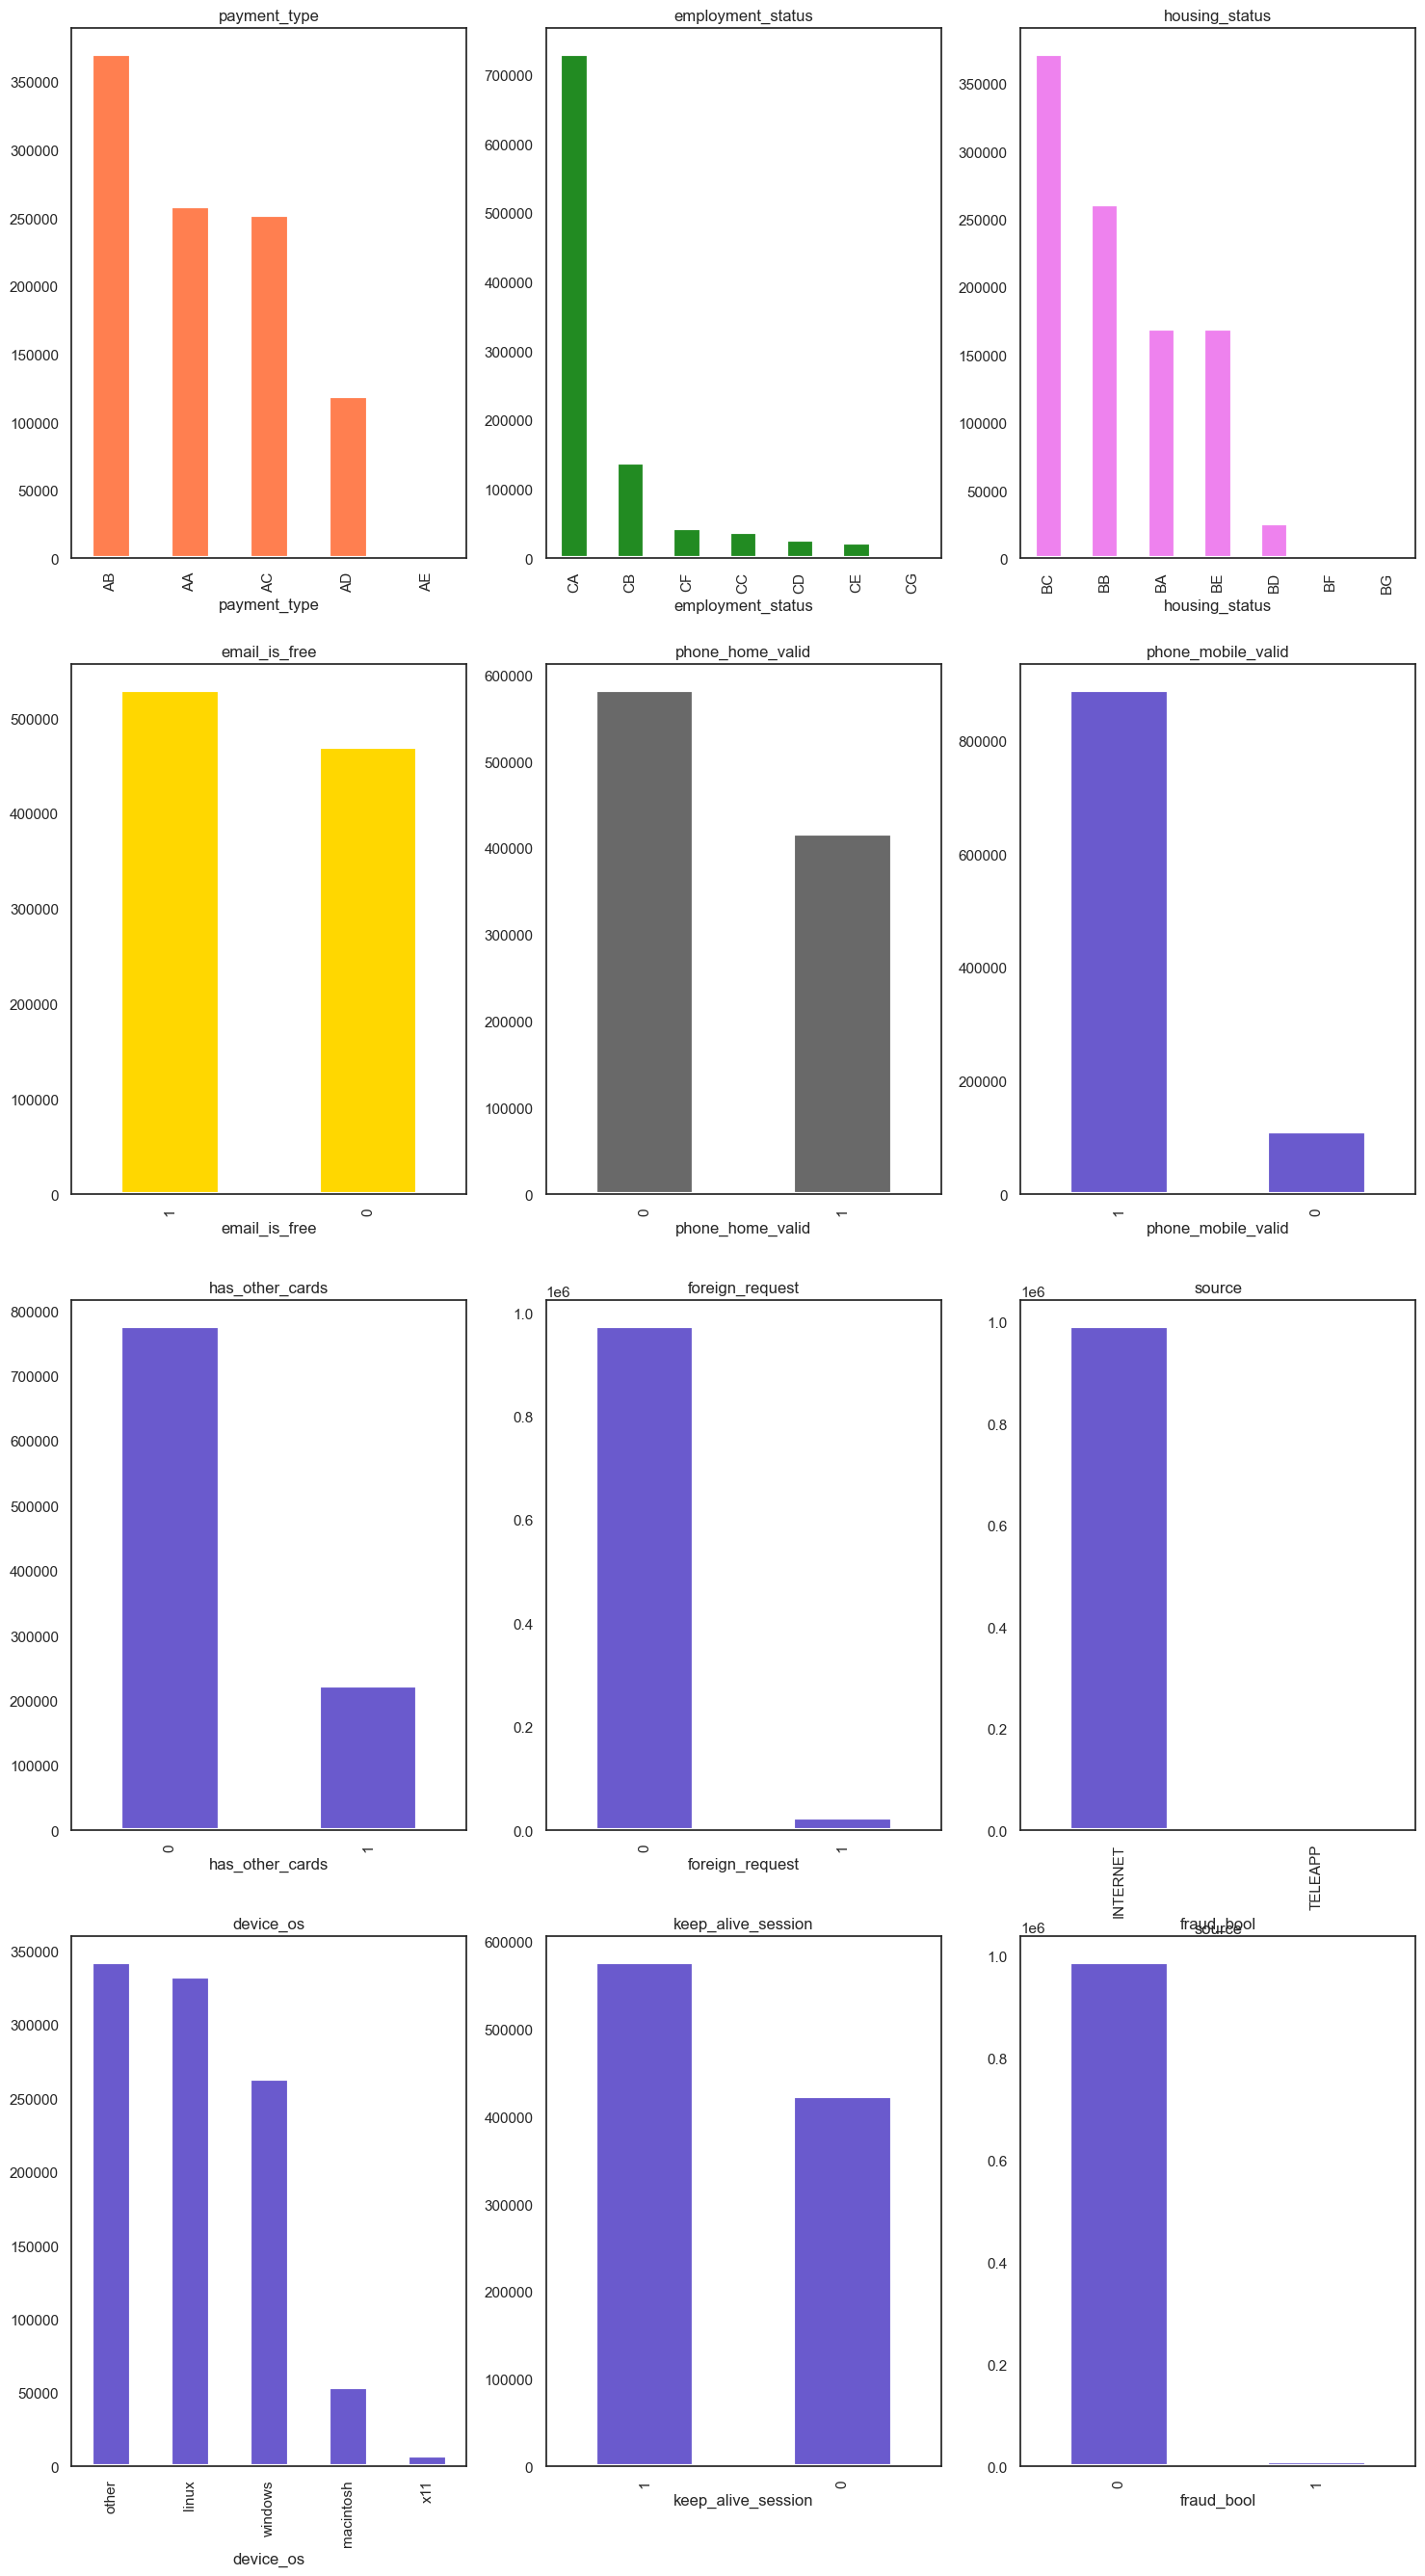

In [38]:
plt.figure(figsize=(18, 50))

plt.subplot(6, 3, 1)
pd_fraud['payment_type'].value_counts().plot(kind='bar',color = 'coral',linewidth = 3,title='payment_type')

plt.subplot(6, 3, 2)
pd_fraud['employment_status'].value_counts().plot(kind='bar',color = 'forestgreen',linewidth = 3,title='employment_status')

plt.subplot(6, 3, 3)
pd_fraud['housing_status'].value_counts().plot(kind='bar',color = 'violet',linewidth = 3,title='housing_status')

plt.subplot(6, 3, 4)
pd_fraud['email_is_free'].value_counts().plot(kind='bar',color = 'gold',linewidth = 3,title='email_is_free')

plt.subplot(6, 3, 5)
pd_fraud['phone_home_valid'].value_counts().plot(kind='bar',color = 'dimgray',linewidth = 3,title='phone_home_valid')

plt.subplot(6, 3, 6)
pd_fraud['phone_mobile_valid'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='phone_mobile_valid')

plt.subplot(6, 3, 7)
pd_fraud['has_other_cards'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='has_other_cards')

plt.subplot(6, 3, 8)
pd_fraud['foreign_request'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='foreign_request')

plt.subplot(6, 3, 9)
pd_fraud['source'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='source')

plt.subplot(6, 3, 10)
pd_fraud['device_os'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='device_os')

plt.subplot(6, 3, 11)
pd_fraud['keep_alive_session'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='keep_alive_session')

plt.subplot(6, 3, 12)
pd_fraud['fraud_bool'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='fraud_bool')

No vemos distribuciones extrañas con las variables categóricas. Sin embargo, podemos comprobar que la variable objetivo 'fraud_bool' está muy desbalanceada por lo que, como ya se ha comentado previamente tendremos que aplicar alguna técnica de balanceo de variables en próximos notebooks.

### Correlaciones

Nuevamente, introducimos las variables para la matriz de correlaciones a mano puesto que únicamente vamos a utilizar las variables numéricas y las continuas, las variables binarias y categóricas no se van a utilizar. Puesto que las variables binarias y numéricas están codificadas ambas como de tipo 'int64', se ha decidido crear la lista a mano.

In [33]:
lista_correlaciones = ["income", "name_email_similarity", "prev_address_months_count", "current_address_months_count", "customer_age", "days_since_request",
                            "intended_balcon_amount", "zip_count_4w", "velocity_6h", "velocity_24h", "velocity_4w", "bank_branch_count_8w", "date_of_birth_distinct_emails_4w",
                            "credit_risk_score", "bank_months_count", "proposed_credit_limit", "session_length_in_minutes", "device_distinct_emails_8w", "device_fraud_count",
                            "month", "fraud_bool"]

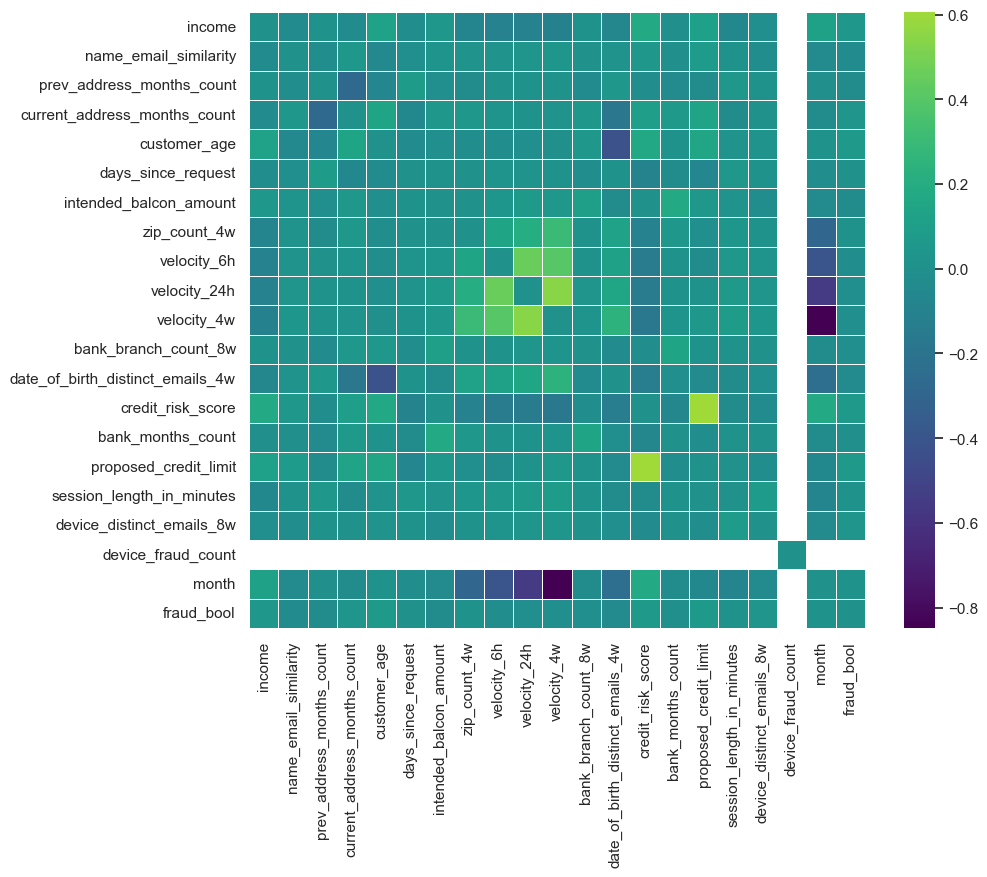

0

In [34]:
get_corr_matrix(dataset = pd_fraud[lista_correlaciones], 
                metodo='pearson', size_figure=[10,8])

 - Observamos una elevada relación entre 'velocity_6h', 'velocity_24h', y 'velocity_4w'. Por lo tanto, se nos ocurre crear una variable que recoja la información de las tres velocidades. Utilizaremos la media aritmética para recoger la información de la forma más fiable posible en el notebook3 (selección de variables).
 - Además podemos destacar que, en valor absoluto, las variables más correlacionadas de la matriz superior son 'month' y 'velocity_4w' con un 84,80% de correlación.
 - También observamos una alta correlación negativa entre 'customer_age' y 'date_of_birth_distinct_emails_4w' por lo tanto consideraremos eliminar una de ellas en selección de variables si lo vemos necesario.
 - No observamos ninguna |correlación| > 0.2 con respecto a la variable objetivo, lo que sería una indicación de que va a ser complicado realizar predicciones importantes.
 - Por último, observamos una correlación significativa entre "proposed_credit_limit" y "credit_risk_score" lo cual tiene sentido debido a que la primera variable influye en el cálculo de la segunda. Puesto que ambas variables nos parecen relevantes en principio ninguna será eliminada del conjunto de datos.

In [35]:
corr = pd_fraud[lista_variables_numericas].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.5]

,level_0,level_1,correlation
391,month,velocity_4w,0.848100
328,proposed_credit_limit,credit_risk_score,0.606141
390,month,velocity_24h,0.549919
219,velocity_4w,velocity_24h,0.539115


Comprobamos las variables que tienen una correlación mayor a un 50%, como se ha comentado al representar la matriz de correlación.

In [19]:
new_corr

,level_0,level_1,correlation
372,month,velocity_4w,0.848100
313,proposed_credit_limit,credit_risk_score,0.606141
371,month,velocity_24h,0.549919
209,velocity_4w,velocity_24h,0.539115
188,velocity_24h,velocity_6h,0.464003
244,date_of_birth_distinct_emails_4w,customer_age,0.420173
370,month,velocity_6h,0.409148
208,velocity_4w,velocity_6h,0.400254
207,velocity_4w,zip_count_4w,0.302955
369,month,zip_count_4w,0.287203


Decidimos en esta primera iteración, no eliminar correlaciones. Sin embargo, si finalmente aplicamos algún algoritmo que lo requiera, tendremos que eliminar correlaciones.

### Tratamiento de valores nulos

In [25]:
lista_variables_numericas

['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'bank_months_count',
 'proposed_credit_limit',
 'session_length_in_minutes',
 'device_distinct_emails_8w',
 'device_fraud_count',
 'month']

In [33]:
get_percent_null_values_target(pd_fraud, lista_variables_numericas, target='fraud_bool')

No existen variables con valores nulos


""


Como ya hemos adelantado en el primer notebook, los missings en este dataset no están codificados como NAs, si no como -1 o como valores negativos. Por esta razón, el código muestra el mensaje: 'No existen variables con valores nulos' a pesar de que todas las variables que contienen missings formen parte de 'lista_variables_numericas'.

Ahora vamos a tratar los valores nulos. Para ello utilizamos el bucle empleado en el notebook 1. Este código proporcionará un resumen de la cantidad y el porcentaje de valores faltantes para las variables del dataframe 'pd_fraud' que se especifica:

In [36]:
variables = ['prev_address_months_count', 'current_address_months_count','intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']
missing_count = []
missing_percentage = []

for variable in variables:
    if variable == 'intended_balcon_amount':
        missing_count.append(pd_fraud[pd_fraud[variable] < 0].shape[0])
    else:
        missing_count.append(pd_fraud[pd_fraud[variable] == -1].shape[0])

    missing_percentage.append((missing_count[-1] /len(pd_fraud) * 100))

missing_data_df = pd.DataFrame({
    'Variable': variables,
    'Missing': missing_count,
    'Porcentaje Missing': missing_percentage
})

missing_data_df

,Variable,Missing,Porcentaje Missing
0,prev_address_months_count,712920,71.2920
1,current_address_months_count,4254,0.4254
2,intended_balcon_amount,742523,74.2523
3,bank_months_count,253635,25.3635
4,session_length_in_minutes,2015,0.2015
5,device_distinct_emails_8w,359,0.0359


#### Conclusiones missings
1. En primer lugar, es comprensible el alto número de missings encontrados en la variable **'prev_address_months_count'**, puesto que es altamente posible que muchos de los solicitantes no se hayan mudado a otra residencia. Puesto que la base de datos a utilizar contiene 1M instancias, comprobamos que esta variable tiene un 70% de missings. Esta cuestión puede ser muy relevante a la hora de decidir si mantener esta variable para el estudio o no, puesto que la información que aporta será mucho menor que la que aportarán otras variables.
2. En segundo lugar, la variable **'current_address_months_count'** tiene 4254 missings. Vemos que los missings son mucho inferiores a los de la anterior variable analizada, puesto que es probable que muchos de los solicitantes hayan estado en su residencia actual varios meses. Sin embargo, cabe destacar que 4254 de ellos no llevan ni un mes viviendo en su residencia actual. Esta variable puede ser muy significativa a efectos de este proyecto, puesto que quizá, dependiendo de los meses que lleve un solicitante viviendo en su residencia actual, haya más posibilidades de que una solicitud resulte fraudulenta o no.
3. La variable **'intended_balcon_amount'** presenta 742.523 missings, lo cual indica que casi nunca se introduce dinero al iniciar una aplicación. Eso sumado a que los gráficos boxplots analizados anteriormente son muy parecidos, indica que esta variable no sería muy útil para el estudio. La añadimos a la lista de variables que consideraremos eliminar.
4. La variable **'bank_months_count'** también presenta un alto número de missings, los cuales pueden representar dos posibles opciones: uno, que los solicitantes no tengan cuentas bancarias previas, o que la misma se ha creado en el momento del estudio y por lo tanto lleva meses creada. Esta variable, aunque con un 25% de missings, podría tener importancia en nuestro estudio puesto que como vimos en los boxplots anteriores, cuando la cuenta bancaria anterior tiene x meses de antigüedad quizá sea más probable que una solicitud resulte fraudulenta.
5. Por otro lado, la variable **'session_length_in_minutes'** presenta 2.015 missings. Estos valores nulos se pueden interpretar como que los solicitantes no han visitado la página web del banco. Al ser un número de missings bajos, no consideramos relevante esta cifra.
6. Por último, la variable **'device_distinct_emails_8w'** presenta 359 missings, cifra muy baja considerando que el dataset tiene 1M de instancias. Como ya hay una clase que representa las personas que no tienen ningún email estas observaciones no ofrecen ninguna información. Será útil hacer un análisis más profundo sobre estas observaciones y las consideraremos eliminar por completo al ser un porcentaje tan bajo sobre el total del data set o imputarlas por la mediana de esta variable.

## - Tratamiento de las variables categóricas

In [27]:
lista_variables_categoricas

['payment_type',
 'employment_status',
 'housing_status',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'foreign_request',
 'source',
 'device_os',
 'keep_alive_session',
 'fraud_bool']

Calculamos la matriz de confusión y el coeficiente de Cramer para ver la relación entre una variable categórica y la variable objetivo:

In [36]:
confusion_matrix = pd.crosstab(pd_fraud["fraud_bool"], pd_fraud["payment_type"])
print(confusion_matrix)
cramers_v(confusion_matrix.values)

payment_type      AA      AB      AC      AD   AE
fraud_bool                                       
0             256885  366385  247862  117551  288
1               1364    4169    4209    1286    1


0.039042842242482736

Coeficiente de Cramer prácticamente nulo por lo que la relación entre ambas variables sería inexistente.

In [37]:
confusion_matrix = pd.crosstab(pd_fraud["fraud_bool"], pd_fraud["fraud_bool"])
cramers_v(confusion_matrix.values)

0.9999541593523196

El resultado obtenido en esta línea de código tiene sentido puesto que la relación existente entre una variable consigo misma es de 1

A continuación a través de un bucle vamos a calcular el coeficiente de Crammer para todas las variables que forman parte de 'lista_variables_categoricas':

In [56]:
for i in lista_variables_categoricas:
    confusion_matrix = pd.crosstab(pd_fraud["fraud_bool"], pd_fraud[i])
    print("El coeficiente de Crammer para la variable "+ str(i) + " es "+ str(cramers_v(confusion_matrix.values)))

El coeficiente de Crammer para la variable payment_type es 0.039042842242482736
El coeficiente de Crammer para la variable employment_status es 0.039579041948826
El coeficiente de Crammer para la variable housing_status es 0.11487732983320799
El coeficiente de Crammer para la variable email_is_free es 0.027730004919501703
El coeficiente de Crammer para la variable phone_home_valid es 0.03510388236282846
El coeficiente de Crammer para la variable phone_mobile_valid es 0.013126368094879885
El coeficiente de Crammer para la variable has_other_cards es 0.03513065449791526
El coeficiente de Crammer para la variable foreign_request es 0.016824420425245186
El coeficiente de Crammer para la variable source es 0.00373333855293764
El coeficiente de Crammer para la variable device_os es 0.08046708891771352
El coeficiente de Crammer para la variable keep_alive_session es 0.05027680351314226


Se observa que las relaciones con la variable objetivo son bastante bajas según el coeficiente de Cramer al igual que el resto de variables. Podemos destacar que, aunque muy baja, la relación con la variable 'housing_status', es la mayor con respecto a la variable objetivo (0.1148)

## Conclusiones

- Con la lectura de datos del preprocesado inicial hemos comprobado que la variable **'device_fraud_count'** toma únicamente el valor 0, información que se contemplará en el apartado de selección de variables.
- El dataset objeto de estudio dispone de variables categóricas, números enteros y variables continuas por lo que 5 variables han sido transformadas a **formato decimal**.
- El conjunto de datos está **desbalanceado** (alrededor de un 99% de las observaciones tienen lugar cuando la variable objetivo 'fraud_bool'= 0).

 - En relación con los gráficos obtenidos se alcanzan distintas conclusiones:

    1) Existe una diferencia clara entre las medias de 'income' cuando medimos los datos fraudulentos contra los no fraudulentos, siendo mucho mayor en los casos en los que se comete fraude. Esto puede llevar a pensar que las cuentas con más income tienden a ser fraudulentas. Un estudio más profundo sobre esta relación podría ser interesante.

    2) Como podemos ver en el gráfico de barras de 'name_email_similarity', la mayoría de la gente pone su nombre en la dirección del email.

    3) Probablemente no tenga relación el nombre del email con la posibilidad de que las aplicaciones sean fraudulentas o no.

    4) Al menos el 50% de las aplicaciones fraudulentas presentan 'prev_address_months_count' como valor faltante (variable que podría ser relevante para detectar los fraudes)

    5) El gráfico de barras de la variable 'customer_age' muestra un dato muy relevante: que se utilizan cuentas de personas más mayores para generar aplicaciones fraudulentas.

    6) En el histograma de 'intended_balcon_amount' podemos ver que casi nunca se introduce dinero al iniciar una aplicación. Eso sumado a que los gráficos boxplots son muy parecidos, indica que esta variable no sería muy útil para el estudio.
    7) En el gráfico de barras de 'date_of_birth_distinct_emails_4w' observamos que hay 4 semanas dignas de mención (0,1,2,36). Un estudio más a fondo podría ser interesante.

    8) A pesar de que en el histograma de 'employment_status' se observen que el que más se repiten son los CA y que los grupos CC y en especial CG apenas carecen de aplicaciones, en el gráfico de barras observamos que el employment_status CC y CG tiende a ser utilizado para crear aplicaciones fraudulentas.

    9) A pesar de que en el histograma de 'housing_status' se observen que el que más se repiten son los BC, en el gráfico de barras observamos que el housing_status BA tiende a ser más utilizado para crear aplicaciones fraudulentas.

    10) En el gráfico de barras de 'bank_months_count' observamos que los usuarios crean más cuentas fraudulentas cuando la cuenta bancaria de un cliente tiene 17 meses.

    11) En el boxplot de 'proposed_credit_limit' se muestra que las aplicaciones fraudulentas se tienden a crear con un límite de cuenta mayor, lo que tiene lógica puesto que se quiere obtener confianza.

    12) En el histograma de 'foreign_request' podemos ver que no hay muchas cuentas con esta variable igual a 1, y en el gráfico de barras entonces podemos observar una ligera diferencia. Cuentas con este valor se pueden llegar a utilizar más para crear aplicaciones fraudulentas.

    13) Gráficos keep_alive_session: Las cuentas con aplicaciones fraudulentas tienden a dejarse la cuenta abierta lo cual tiene sentido porque así no se requiere introducir contraseñas.

    14) Las aplicaciones fraudulentas es probable que se creen desde el mismo dispositivo, y esto puede explicar que en el gráfico de barras de 'device_distinct_emails_8w' el valor que más se repita sea el 2.

    El resto de variables no contienen información relevante o destacable dentro de sus boxplot e histogramas.
    

- **Tratamiento variables numéricas**: 
     - Tras analizar los **outliers**, no hemos encontrado outliers significativos que puedan dañar el análisis por lo que no vamos a realizar modificaciones sobre estos.
    
     - **Correlaciones**: Observamos una elevada relación entre 'velocity_6h', 'velocity_24h', y 'velocity_4w', por lo que vamos a crear una variable que recoja la información de las tres velocidades con su media aritmética en el apartado de selección de variables.
         Además podemos destacar que, en valor absoluto, las variables más correlacionadas de la matriz superior son 'month' y 'velocity_4w' con un 84,80% de correlación.
        También observamos una alta correlación negativa entre 'customer_age' y 'date_of_birth_distinct_emails_4w' por lo tanto consideraremos eliminar una de ellas en selección de variables si lo vemos necesario.
        No observamos ninguna |correlación| > 0.2 con respecto a la variable objetivo, lo que sería una indicación de que va a ser complicado realizar predicciones importantes.
        Por último, observamos una correlación significativa entre "proposed_credit_limit" y "credit_risk_score" lo cual tiene sentido debido a que la primera variable influye en el cálculo de la segunda. Puesto que ambas variables nos parecen relevantes en principio ninguna será eliminada del conjunto de datos.
    
    - **Valores nulos**: 
        El mayor porcentaje de missings se corresponde con las variables **'intended_balcon_amount'** y **'prev_address_months_count'** (742523 y 712920	missings, respectivamente). En primer lugar, es comprensible el alto número de missings encontrados en la variable 'prev_address_months_count', puesto que es altamente posible que muchos de los solicitantes no se hayan mudado a otra residencia. Esta cuestión puede ser muy relevante a la hora de decidir si mantener esta variable para el estudio o no, puesto que la información que aporta será mucho menor que la que aportarán otras variables. En segundo lugar, el elevado número de missings en la variable 'intended_balcon_amount' indica que casi nunca se introduce dinero al iniciar una aplicación. Eso sumado a que los gráficos boxplots analizados anteriormente son muy parecidos, indica que esta variable no sería muy útil para el estudio. La añadimos a la lista de variables que consideraremos eliminar.
        Otra variable que presenta un elevado número de missings es **'bank_months_count'** los cuales pueden representar que los solicitantes no tengan cuentas bancarias previas, o que la misma se ha creado en el momento del estudio y por lo tanto lleva meses creada. Esta variable, aunque con un 25% de missings, podría tener importancia en nuestro estudio puesto que como vimos en los boxplots anteriores.

- **Tratamiento variables categóricas**: 
    el coeficiente de Crammer muestra que la relación existente entre las variables categóricas y la variable objetivo son muy bajas, siendo la mayor la relativa a 'housing_status'(0.1148)

Guardamos en csv todos el dataframe con las modificaciones realizadas:

In [57]:
pd_fraud.to_csv("data/pd_fraud_02.csv")